# Downloading the LiDAR data of the Dutch coast
This notebook gives a toturial of downloanding LiDAR data for the Dutch coast.

In [1]:
# Import packages
import logging
import json
import os
import urlparse

logging.root.setLevel(logging.DEBUG)

# computing
import numpy as np

#plotting
import matplotlib.pyplot as plt
%matplotlib inline

# for spatial types
import owslib.wfs
import owslib.wms
# for spatial operations
import shapely.geometry
from matplotlib import collections

# for pointclouds
import liblas
from liblas import file

# numpy compatible, uncompressed only for now
import laspy.file
# for downloading
import requests
#  for xml parsing
import lxml.etree
import mako

# for aerial photo saturation
import skimage as ski
import gdal

os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib"

In [2]:
# Enter WFS properties
wfsurl = 'http://geodata.nationaalgeoregister.nl/ahn2/wfs'
wfs = owslib.wfs.WebFeatureService(wfsurl, version="2.0.0")
wfslayer = wfs.contents['ahn2:ahn2_bladindex']

# Get boxes from WFS
f = wfs.getfeature(typename=[wfslayer.id], outputFormat="json")
data = json.load(f)  # Coordinate system, 5 coordinates per polygon, bladnr

shapes = []
tiles = []

# create a list of tiles and shapes
for feature in data['features']:
    shapes.append(shapely.geometry.asShape(feature['geometry'])[0])
    tiles.append(shapes[-1].exterior.coords[:])

DEBUG:owslib:building WFS http://geodata.nationaalgeoregister.nl/ahn2/wfs
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?service=WFS&request=GetCapabilities&version=2.0.0 HTTP/1.1" 200 5817
DEBUG:owslib:building WFS http://geodata.nationaalgeoregister.nl/ahn2/wfs
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?service=WFS&request=GetCapabilities&version=2.0.0 HTTP/1.1" 200 5817
DEBUG:owslib:GetFeature WFS GET url http://geodata.nationaalgeoregister.nl/ahn2/wfs?typename=ahn2%3Aahn2_bladindex&outputFormat=json&version=2.0.0&request=GetFeature&service=WFS
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?typename=ahn2%

The coordinates are in the Dutch RijksDriehoekstelsel.

In [3]:
# Referencing
import osgeo.osr
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
rd = osgeo.osr.SpatialReference()
rd.ImportFromEPSG(28992)
wgs842rd = osgeo.osr.CoordinateTransformation(wgs84, rd)

The Dutch coast is arbitrarely choosen as a polygon. All tiles inside this polygon cover at least some part of the coast.

total of  213
[u'02ez1', u'02ez2', u'02fz1', u'02fz2', u'03dz1', u'01gn2', u'01hn1', u'01hn2', u'02cn1', u'02cn2', u'02dn1', u'02gn1', u'02gn2', u'02hn1', u'02hn2', u'03dn1', u'03dn2', u'03gn1', u'03gn2', u'03hn1', u'01cz2', u'01dz1', u'01dz2', u'01gz1', u'01gz2', u'01hz1', u'01hz2', u'02cz1', u'02cz2', u'02dz1', u'02dz2', u'02gz1', u'02gz2', u'02hz1', u'02hz2', u'03cz1', u'03cz2', u'03dz2', u'03gz1', u'03gz2', u'04fn2', u'05an1', u'05an2', u'05bn1', u'05fn1', u'05fn2', u'06an1', u'06an2', u'06bn1', u'06bn2', u'06en1', u'06en2', u'06fn1', u'06fn2', u'07an1', u'07an2', u'04ez2', u'04fz1', u'04fz2', u'05ez2', u'05fz1', u'05fz2', u'06az1', u'06az2', u'06bz1', u'06bz2', u'06ez1', u'04dn2', u'04gn1', u'04gn2', u'05dn2', u'05gn1', u'05gn2', u'05hn1', u'05hn2', u'06cn1', u'04dz2', u'04gz1', u'05dz2', u'05gz1', u'09bn1', u'09bn2', u'09en1', u'10bn1', u'10bn2', u'09az2', u'09bz1', u'09bz2', u'09ez1', u'10az2', u'10bz1', u'09cn2', u'09dn1', u'09dn2', u'09hn2', u'10cn1', u'09cz2', u'09dz1', u'09d

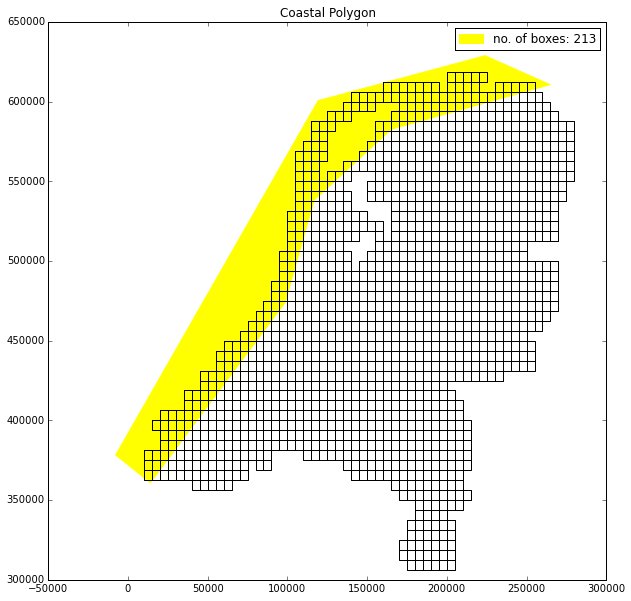

In [4]:
#Finding tiles of coast

# Coast bounding box coordinates
lat = [51.37, 53.39, 53.64, 53.47, 53.23, 52.83, 52.25, 51.22, 51.37]  # closed ring, last = first
lon = [3.05, 4.85, 6.43, 7.04, 5.54, 4.82, 4.56, 3.37, 3.05]

coords = []
for i in range(len(lat)):
    x, y, _ = wgs842rd.TransformPoint(lon[i], lat[i])
    coords.append((x, y))

polygon = shapely.geometry.Polygon(coords)
x_poly, y_poly = polygon.exterior.xy

coastal_tiles = []
for j in range(len(tiles)):
    x_min = tiles[j][0][0]
    y_min = tiles[j][0][1]
    p = shapely.geometry.Point(x_min, y_min)
    
    if p.within(polygon):
        bladnr = data['features'][j]['properties']['bladnr']
        if bladnr not in coastal_tiles:
            coastal_tiles.append(bladnr)

print 'total of ', len(coastal_tiles)
print coastal_tiles

# Plot coastal zone using a collection
col = collections.LineCollection(tiles, colors='k')
fig, ax  = plt.subplots()
fig.set_size_inches(10, 10)
fig.patch.set_facecolor('white')
ax.add_collection(col, autolim=True)
ax.set_aspect('equal')
ax.autoscale_view()

plt.fill(x_poly, y_poly, color='yellow', label='no. of boxes: ' + str(len(coastal_tiles)))
plt.title('Coastal Polygon')
plt.legend(loc='best');